## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from oqd_core.interface.atomic import *

from oqd_trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

muted_palette = sns.color_palette("muted", n_colors=10, desat=0.8)

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 10,
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
)
estate2 = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 200,
)

transitions = [
    Transition(
        level1=downstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=downstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(energy=0.1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 5,
    detuning=2 * np.pi * 25,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[2],
    rabi=2 * np.pi * 5,
    detuning=2 * np.pi * 25,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=10),
        Pulse(beam=beam2, duration=6),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("3_example_uneven.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("3_example_uneven.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend(solver_options=dict(progress_bar=True))

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

### Results


In [7]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

10.0%. Run time:   5.98s. Est. time left: 00:00:00:53


20.0%. Run time:  12.04s. Est. time left: 00:00:00:48


30.0%. Run time:  18.16s. Est. time left: 00:00:00:42


40.0%. Run time:  24.25s. Est. time left: 00:00:00:36


50.1%. Run time:  30.37s. Est. time left: 00:00:00:30


60.1%. Run time:  36.50s. Est. time left: 00:00:00:24


70.1%. Run time:  41.91s. Est. time left: 00:00:00:17


80.1%. Run time:  47.27s. Est. time left: 00:00:00:11


90.1%. Run time:  52.64s. Est. time left: 00:00:00:05


100.0%. Run time:  57.98s. Est. time left: 00:00:00:00


Total run time:  57.98s


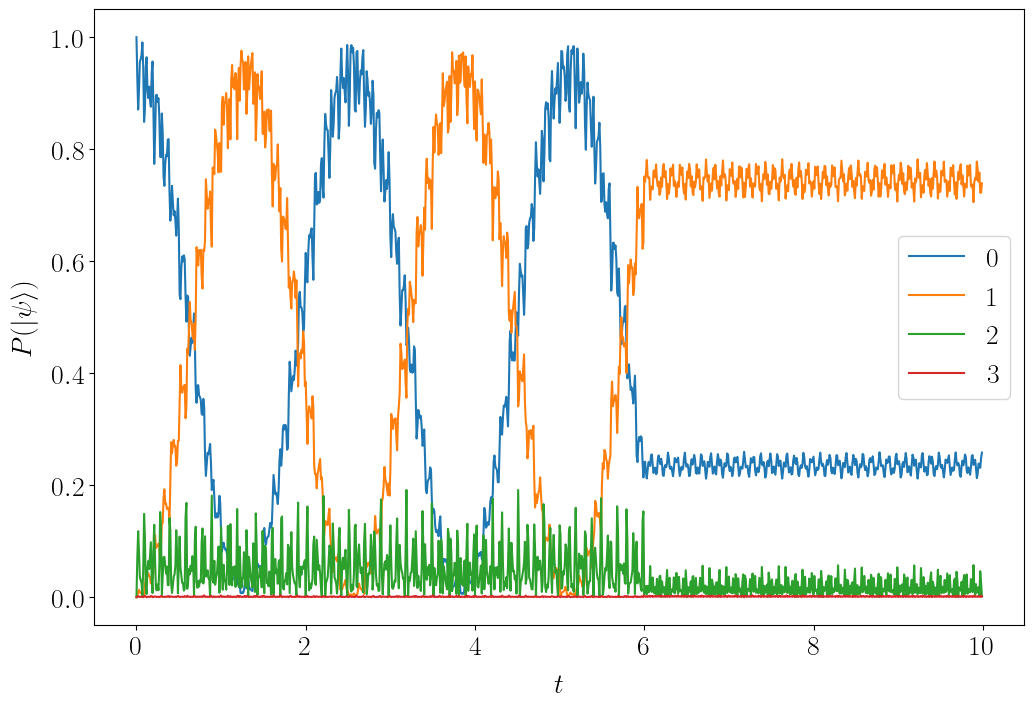

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:4] for s in result["states"][k]],
    label=range(4),
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()